In [115]:
'''
Description: TP2 de cours EDP in finance
Version: 1.0
Author: SHAO Nuoya, WU Zeyuan
Date: 2021-12-17 14:01:37
LastEditors: SHAO Nuoya
LastEditTime: 2021-12-17 14:03:57
'''


'\nDescription: TP2 de cours EDP in finance\nVersion: 1.0\nAuthor: SHAO Nuoya, WU Zeyuan\nDate: 2021-12-17 14:01:37\nLastEditors: SHAO Nuoya\nLastEditTime: 2021-12-17 14:03:57\n'

In [116]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
from scipy.sparse import csr_matrix as sparse
from scipy.sparse.linalg import spsolve
from scipy.linalg import lu

In [161]:
class BS:
    def __init__(self,
                 K=100,
                 S_min=50,
                 S_max=250,
                 T=1,
                 sigma=0.3,
                 r=0.1,
                 N=10,
                 I=10):
        self.K = K
        self.S_min = S_min
        self.S_max = S_max
        self.T = T
        self.sigma = sigma
        self.r = r
        self.N = N
        self.I = I

        self.h = (S_max - S_min) / (I + 1)
        self.dt = T / N

        self.S = S_min + self.h * np.arange(1, I + 1).reshape(-1, 1)
        self.Sval = 90
        self.alpha = sigma**2 * self.S**2 / (2 * self.h**2)
        self.beta = r * self.S / (2 * self.h)

    def get_A(self) -> np.ndarray:
        I = self.I
        A = np.zeros((I, I))
        for i in range(I):
            A[i, i] = 2 * self.alpha[i] + self.r

        for i in range(I - 1):
            A[i + 1, i] = -self.alpha[i + 1] + self.beta[i + 1]
            A[i, i + 1] = -self.alpha[i] - self.beta[i]
        return sparse(A)

    # Boundary condition
    def phi(self) -> np.ndarray:
        return np.maximum(self.K - self.S, 0).reshape(-1, 1)

    def phi2(self) -> np.ndarray:
        K, S = self.K, self.S
        n = S.shape[0]
        ans = np.array([0 for _ in range(n)]).reshape(-1, 1)

        ans[((K / 2 <= S) & (S <= K))] = K
        return ans

    def uleft(self) -> float:
        return (-self.alpha[0] + self.beta[0]) * (self.K - self.S_min)

    def uright(self) -> float:
        return 0

    def uleft2(self) -> float:
        return 0

    def uright2(self) -> float:
        return 0

    def PSOR(self, x: np.ndarray, B: np.ndarray, b: np.ndarray, g: np.ndarray,
             eta: float, k_max: int) -> np.ndarray:
        x_old = x.copy()
        k = 0
        err = 1
        errs = [err]
        while (err > eta and k < k_max):
            for i in range(len(x)):
                x[i] = (b[i] - ((B @ x)[i] - B[i, i] * x[i])) / B[i, i]
                x[i] = max(x[i], g[i])

            err = np.linalg.norm(np.abs(x - x_old), np.inf)
            x_old = x.copy()
            k += 1
            errs.append(round(err, 5))
        print("Errors of current time step: \n", errs, '\n')
        return x

    def newton(self, x: np.ndarray, B: np.ndarray, b: np.ndarray, eta: float,
               k_max: int) -> np.ndarray:
        g = self.phi()
        k = 0
        err = 1
        errs = [err]
        F_prime = np.eye(B.shape[0])

        while (err > eta and k < k_max):
            for i in range(B.shape[0]):
                if (B @ x - b)[i][0] <= (x - g)[i]:
                    F_prime[i] = B[i]

            x_new = x - np.linalg.inv(F_prime) @ np.minimum(B @ x - b, x - g)
            err = np.linalg.norm(np.abs(x_new - x), np.inf)
            x = x_new.copy()
            k += 1
            errs.append(round(err, 5))
        print("Errors of current time step: \n", errs, '\n')
        return x

    def uldecomp(self, B: np.ndarray) -> list[np.ndarray]:
        P, L, U = lu(B)
        return U, P @ L

    def descente_p(self, x, L, b, g, eta, k_max):
        return self.PSOR(x, L, b, g, eta, k_max)

    def get_price(self, method: str, payoff=1) -> np.ndarray:
        I, dt, g, A = self.I, self.dt, self.phi(), self.get_A()
        U = self.phi()
        q = np.zeros((I, 1))
        B = np.eye(I) + dt * A
        b = U - dt * q

        for t in range(self.N):
            q[0] = self.uleft()
            q[-1] = self.uright()
            if method == 'EE':
                U = np.maximum(U - dt * (A @ U + q), g)

            if method == 'IE':
                Id = sparse(np.eye(I))
                U1 = spsolve(A + Id / dt, Id / dt @ U - q)
                U1 = U1.reshape(I, 1)
                U = np.maximum(U1, g)

            if method == 'CN':
                Id = sparse(np.eye(I))
                U1 = spsolve(A / 2 + Id / dt, (-A / 2 + Id / dt) @ U - q)
                U1 = U1.reshape(I, 1)
                U = np.maximum(U1, g)

            if method == 'EI-AMER-PSOR':
                U = self.PSOR(U, B, b, g, 0.01, 100)

            if method == 'Semi-Smooth-Newton':
                U = self.newton(U, B, b, 0.01, 100)

            if method == 'EI-AMER-UL':
                if payoff == 2:
                    q[0] = self.uleft2()
                    q[-1] = self.uright2()
                    g = self.phi2()
                u, l = self.uldecomp(B)
                if t == 0:
                    print('norm de B-UL: ', np.linalg.norm(B - u @ l, np.inf))
                c = np.linalg.inv(u) @ b
                U = self.descente_p(U, l, c, g, 0.01, 100)

            if method == 'BDF':
                Id = np.eye(I)
                if t == 0:
                    U0 = U.copy()
                    U1 = self.get_price('IE')
                B_ = 3 * Id / 2 + dt * A
                b_ = 2 * U1 - U0 / 2 - dt * q
                U = self.PSOR(U, B_, b_, g, 0.1, 100)
                U0 = U1.copy()
                U1 = U.copy()

        return U

In [118]:
def plot(method: str, I: int, N: int, payoff=1) -> None:
    bs = BS(I=I, N=N)
    U = bs.get_price(method, payoff)

    plt.plot(bs.S, U)
    if payoff==1:
        plt.plot(bs.S, bs.phi(), linestyle='--')
    elif payoff==2:
        plt.plot(bs.S, bs.phi2(), linestyle='--')
    plt.title('I = {}, N = {}, K = {}'.format(bs.I, bs.N, bs.K))
    plt.xlabel('S0')
    plt.ylabel('Payoff')
    plt.grid()

# 1. Explicit Euler Scheme

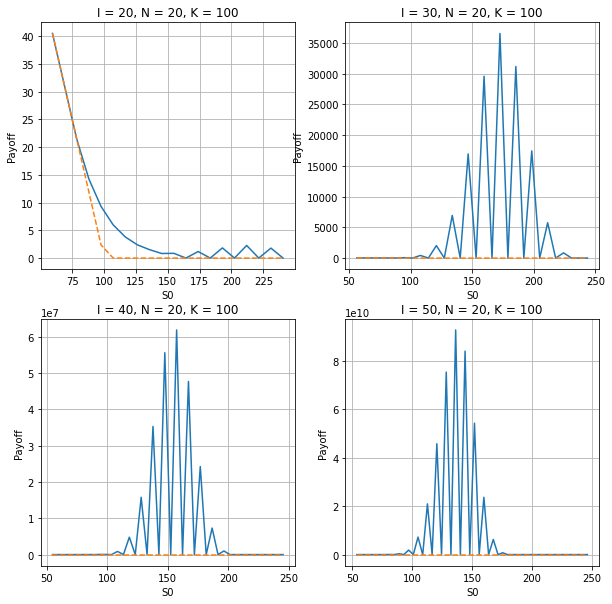

In [119]:
Is = [20, 30, 40, 50]
N = 20
  
plt.figure(figsize=(10, 10))
for i in range(len(Is)):
    plt.subplot(2,2,i+1)
    I = Is[i]
    plot('EE', I, N)

In [120]:
def dic() -> dict:
    dic = {'I': [], 'N': [], 'U(s_)': [], 'e_k': [], 'order_alpha_k': []}
    return dic


def get_order_alpha(e_k_1, e_k, h_k_1, h_k) -> float:
    return np.log(e_k_1 / e_k) / np.log(h_k_1 / h_k)

def P1(s_bar, bs, method):
    U = bs.get_price(method).reshape(-1,1)

    for i in range(len(bs.S)):
        if bs.S[i] <= s_bar and bs.S[i + 1] >= s_bar:
            index = i
            break
    s_i = bs.S[index]
    s_ii = bs.S[index + 1]
    P1_S = (s_ii - s_bar) * U[index] / bs.h + (s_bar - s_i) * U[index +
                                                                1] / bs.h

    return P1_S[0]

In [121]:
Is = [19, 39, 79, 159, 319]
hs = []

dictionary = dic()
dictionary['e_k'].append(None)
dictionary['order_alpha_k'].extend([None, None])

for i in range(len(Is)):
    I = Is[i]
    N = 2*(I+1)**2//10
    bs = BS(N=N, I=I)
    s_ = bs.Sval
    U_s = P1(s_, bs, 'EE')
    hs.append(bs.h)
    dictionary['I'].append(I)
    dictionary['N'].append(N)
    dictionary['U(s_)'].append(U_s)
    if i > 0:
        dictionary['e_k'].append(dictionary['U(s_)'][i] -
                                 dictionary['U(s_)'][i - 1])
    if i > 1:
        e_k_1, e_k = dictionary['e_k'][i - 1:i + 1]
        h_k_1, h_k = hs[i - 1:i + 1]
        dictionary['order_alpha_k'].append(
            get_order_alpha(e_k_1, e_k, h_k_1, h_k))

df = pd.DataFrame.from_dict(dictionary)
df.round(5)

,I,N,U(s_),e_k,order_alpha_k
0,19,80,12.94710,NaN,NaN
1,39,320,13.06472,0.11762,NaN
2,79,1280,13.10957,0.04485,1.39078
3,159,5120,13.11780,0.00823,2.44578
4,319,20480,13.11999,0.00218,1.91530


# 2. A first implicit scheme: the splitting scheme

## SCHEME = 'EI-AMER-SPLIT'

In [122]:
hs = []

dictionary = dic()
dictionary['e_k'].append(None)
dictionary['order_alpha_k'].extend([None, None])

for k in range(6):
    I = 20*2**k-1
    N = 20*2**k
    bs = BS(N=N, I=I)
    s_ = bs.Sval
    U_s = P1(s_, bs, 'IE')
    hs.append(bs.h)
    dictionary['I'].append(I)
    dictionary['N'].append(N)
    dictionary['U(s_)'].append(U_s)
    if k > 0:
        dictionary['e_k'].append(dictionary['U(s_)'][k] -
                                 dictionary['U(s_)'][k - 1])
    if k > 1:
        e_k_1, e_k = dictionary['e_k'][k - 1:k + 1]
        h_k_1, h_k = hs[k - 1:k + 1]
        dictionary['order_alpha_k'].append(
            get_order_alpha(e_k_1, e_k, h_k_1, h_k))

df = pd.DataFrame.from_dict(dictionary)
df.round(5)

,I,N,U(s_),e_k,order_alpha_k
0,19,20,12.77115,NaN,NaN
1,39,40,12.95893,0.18778,NaN
2,79,80,13.05483,0.09590,0.96936
3,159,160,13.08979,0.03496,1.45603
4,319,320,13.10560,0.01581,1.14481
5,639,640,13.11323,0.00763,1.05141


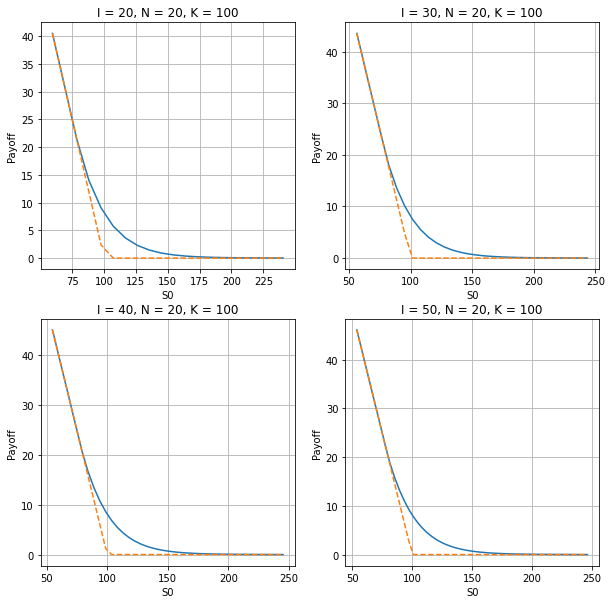

In [123]:
Is = [20, 30, 40, 50]
N = 20
  
plt.figure(figsize=(10, 10))
for i in range(len(Is)):
    plt.subplot(2,2,i+1)
    I = Is[i]
    plot('IE', I, N)

## SCHEME = 'splitting-Crank-Nicolson'

In [124]:
hs = []

dictionary = dic()
dictionary['e_k'].append(None)
dictionary['order_alpha_k'].extend([None, None])

for k in range(6):
    I = 20*2**k-1
    N = 20*2**k
    bs = BS(N=N, I=I)
    s_ = bs.Sval
    U_s = P1(s_, bs, 'CN')
    hs.append(bs.h)
    dictionary['I'].append(I)
    dictionary['N'].append(N)
    dictionary['U(s_)'].append(U_s)
    if k > 0:
        dictionary['e_k'].append(dictionary['U(s_)'][k] -
                                 dictionary['U(s_)'][k - 1])
    if k > 1:
        e_k_1, e_k = dictionary['e_k'][k - 1:k + 1]
        h_k_1, h_k = hs[k - 1:k + 1]
        dictionary['order_alpha_k'].append(
            get_order_alpha(e_k_1, e_k, h_k_1, h_k))

df = pd.DataFrame.from_dict(dictionary)
df.round(5)

,I,N,U(s_),e_k,order_alpha_k
0,19,20,12.88885,NaN,NaN
1,39,40,13.02190,0.13305,NaN
2,79,80,13.09098,0.06908,0.94553
3,159,160,13.10781,0.01682,2.03795
4,319,320,13.11498,0.00717,1.22991
5,639,640,13.11799,0.00301,1.25097


# Implicit Euler Scheme

## 3.1 PSOR Algorithm (PSOR = 'Projected Successive Over Relaxation')

Errors of current time step: 
 [1, 0.93577, 0.41292, 0.27179, 0.19989, 0.15852, 0.12676, 0.10502, 0.08809, 0.07432, 0.06325, 0.05415, 0.04674, 0.04056, 0.03534, 0.03089, 0.02706, 0.02375, 0.02088, 0.01839, 0.01623, 0.01434, 0.01268, 0.01125, 0.01001, 0.00892] 

Errors of current time step: 
 [1, 0.00796] 

Errors of current time step: 
 [1, 0.00711] 

Errors of current time step: 
 [1, 0.00636] 

Errors of current time step: 
 [1, 0.00569] 

Errors of current time step: 
 [1, 0.0051] 

Errors of current time step: 
 [1, 0.00457] 

Errors of current time step: 
 [1, 0.00411] 

Errors of current time step: 
 [1, 0.00371] 

Errors of current time step: 
 [1, 0.00334] 



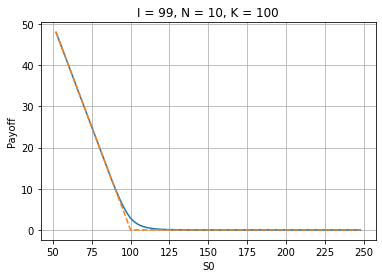

In [125]:
I = 99
N = 10
plot('EI-AMER-PSOR', I, N)

Errors of current time step: 
 [1, 0.48896, 0.2336, 0.1686, 0.13559, 0.11468, 0.10009, 0.08898, 0.08024, 0.07304, 0.06703, 0.06191, 0.05745, 0.05353, 0.05007, 0.04697, 0.04418, 0.04164, 0.03933, 0.03722, 0.03528, 0.03349, 0.03183, 0.03029, 0.02885, 0.02751, 0.02626, 0.02508, 0.02398, 0.02294, 0.02196, 0.02104, 0.02016, 0.01934, 0.01855, 0.01781, 0.01711, 0.01644, 0.01581, 0.0152, 0.01463, 0.01408, 0.01355, 0.01305, 0.01257, 0.01211, 0.01168, 0.01126, 0.01086, 0.01048, 0.01012, 0.00977] 

Errors of current time step: 
 [1, 0.00944] 

Errors of current time step: 
 [1, 0.00912] 

Errors of current time step: 
 [1, 0.00881] 

Errors of current time step: 
 [1, 0.00852] 

Errors of current time step: 
 [1, 0.00823] 

Errors of current time step: 
 [1, 0.00796] 

Errors of current time step: 
 [1, 0.0077] 

Errors of current time step: 
 [1, 0.00745] 

Errors of current time step: 
 [1, 0.0072] 



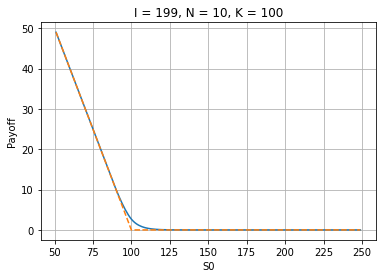

In [126]:
I = 199
N = 10
plot('EI-AMER-PSOR', I, N)

We see clearly that with larger I value, a more important number of PSOR iterations is needed

## 3.2 Semi-smooth Newton's method

Errors of current time step: 
 [1, 1.65436, 0.22223, 0.0] 

Errors of current time step: 
 [1, 0.0] 

Errors of current time step: 
 [1, 0.0] 

Errors of current time step: 
 [1, 0.0] 

Errors of current time step: 
 [1, 0.0] 

Errors of current time step: 
 [1, 0.0] 

Errors of current time step: 
 [1, 0.0] 

Errors of current time step: 
 [1, 0.0] 

Errors of current time step: 
 [1, 0.0] 

Errors of current time step: 
 [1, 0.0] 

Errors of current time step: 
 [1, 0.0] 

Errors of current time step: 
 [1, 0.0] 

Errors of current time step: 
 [1, 0.0] 

Errors of current time step: 
 [1, 0.0] 

Errors of current time step: 
 [1, 0.0] 

Errors of current time step: 
 [1, 0.0] 

Errors of current time step: 
 [1, 0.0] 

Errors of current time step: 
 [1, 0.0] 

Errors of current time step: 
 [1, 0.0] 

Errors of current time step: 
 [1, 0.0] 



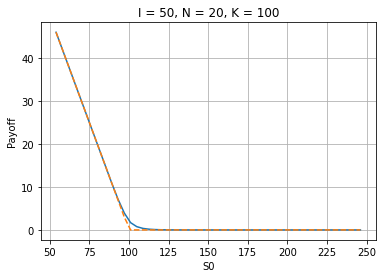

In [127]:
I = 50
N = 20
plot('Semi-Smooth-Newton', I, N)

## 3.3 Brennan and Schwartz algorithm

### Classical payoff function : $\phi_1$

norm de B-UL:  6.501662783390035
Errors of current time step: 
 [1, 1.819, 0.0] 

Errors of current time step: 
 [1, 0.0] 

Errors of current time step: 
 [1, 0.0] 

Errors of current time step: 
 [1, 0.0] 

Errors of current time step: 
 [1, 0.0] 

Errors of current time step: 
 [1, 0.0] 

Errors of current time step: 
 [1, 0.0] 

Errors of current time step: 
 [1, 0.0] 

Errors of current time step: 
 [1, 0.0] 

Errors of current time step: 
 [1, 0.0] 

Errors of current time step: 
 [1, 0.0] 

Errors of current time step: 
 [1, 0.0] 

Errors of current time step: 
 [1, 0.0] 

Errors of current time step: 
 [1, 0.0] 

Errors of current time step: 
 [1, 0.0] 

Errors of current time step: 
 [1, 0.0] 

Errors of current time step: 
 [1, 0.0] 

Errors of current time step: 
 [1, 0.0] 

Errors of current time step: 
 [1, 0.0] 

Errors of current time step: 
 [1, 0.0] 



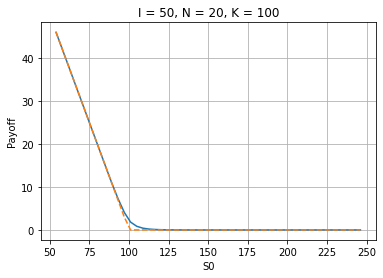

In [128]:
I = 50
N = 20
plot('EI-AMER-UL', I, N, payoff=1)

### Payoff function : $\phi_2$

norm de B-UL:  6.501662783390035
Errors of current time step: 
 [1, 97.05882, 0.0] 

Errors of current time step: 
 [1, 0.0] 

Errors of current time step: 
 [1, 0.0] 

Errors of current time step: 
 [1, 0.0] 

Errors of current time step: 
 [1, 0.0] 

Errors of current time step: 
 [1, 0.0] 

Errors of current time step: 
 [1, 0.0] 

Errors of current time step: 
 [1, 0.0] 

Errors of current time step: 
 [1, 0.0] 

Errors of current time step: 
 [1, 0.0] 

Errors of current time step: 
 [1, 0.0] 

Errors of current time step: 
 [1, 0.0] 

Errors of current time step: 
 [1, 0.0] 

Errors of current time step: 
 [1, 0.0] 

Errors of current time step: 
 [1, 0.0] 

Errors of current time step: 
 [1, 0.0] 

Errors of current time step: 
 [1, 0.0] 

Errors of current time step: 
 [1, 0.0] 

Errors of current time step: 
 [1, 0.0] 

Errors of current time step: 
 [1, 0.0] 



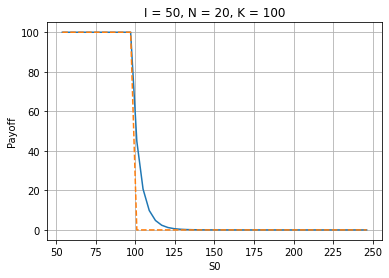

In [129]:
I = 50
N = 20
plot('EI-AMER-UL', I, N, payoff=2)

# 4 A higher order scheme

We have $$min(\frac{3U^{n+1}-4U^n+U^{n-1}}{2\Delta t}+AU^{n+1}+q(t_{n+1}), U^{n+1}-g)=0 $$

Note $$B:=\frac{3I_d}{2}+\Delta tA,\quad and\quad  b=2U^n-\frac{U^{n-1}}{2}-\Delta tq(t_{n+1})$$

Hence the problem can be transformed to 
$$min(Bx-b, x-g)=0, \quad in \ \mathbf{R}^I$$

### N = I

Errors of current time step: 
 [1, 7.7227, 1.99456, 0.51805, 0.13645, 0.03788] 

Errors of current time step: 
 [1, 0.48046, 0.13751, 0.03946] 

Errors of current time step: 
 [1, 0.15483, 0.04475] 

Errors of current time step: 
 [1, 0.09598] 

Errors of current time step: 
 [1, 0.07886] 

Errors of current time step: 
 [1, 0.06978] 

Errors of current time step: 
 [1, 0.06238] 

Errors of current time step: 
 [1, 0.05545] 

Errors of current time step: 
 [1, 0.04891] 

Errors of current time step: 
 [1, 0.04454] 

Errors of current time step: 
 [1, 0.04038] 

Errors of current time step: 
 [1, 0.03633] 

Errors of current time step: 
 [1, 0.0325] 

Errors of current time step: 
 [1, 0.02895] 

Errors of current time step: 
 [1, 0.02571] 

Errors of current time step: 
 [1, 0.02279] 

Errors of current time step: 
 [1, 0.02164] 

Errors of current time step: 
 [1, 0.02107] 

Errors of current time step: 
 [1, 0.02054] 

Errors of current time step: 
 [1, 0.02005] 

Errors of current t

,I,N,U(s_),e_k,order_alpha_k
0,50,50,15.18195,NaN,NaN
1,100,100,15.09553,-0.08642,NaN
2,150,150,15.01991,-0.07562,0.33189
3,200,200,14.98545,-0.03446,2.74798


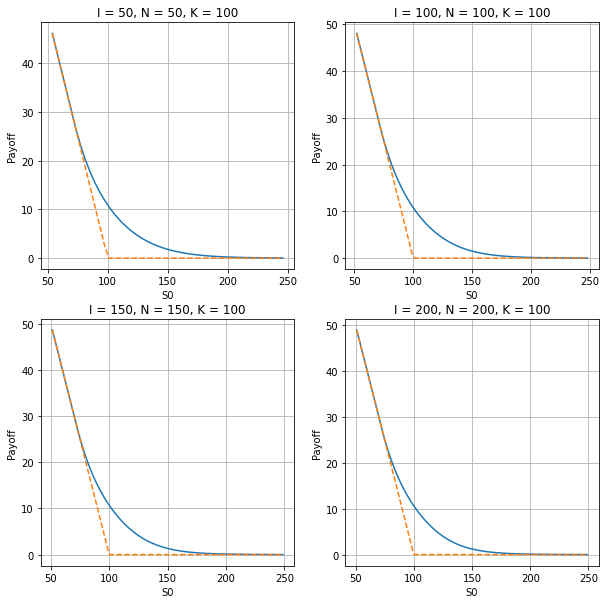

In [164]:
hs = []

dictionary = dic()
dictionary['e_k'].append(None)
dictionary['order_alpha_k'].extend([None, None])
  
Is = [50, 100, 150, 200]
plt.figure(figsize=(10, 10))
for i in range(len(Is)):
    plt.subplot(2,2,i+1)
    I = Is[i]
    N = I
    plot('BDF', I, N)
    
    bs = BS(N=N, I=I)
    s_ = bs.Sval
    U_s = P1(s_, bs, 'BDF')
    hs.append(bs.h)
    dictionary['I'].append(I)
    dictionary['N'].append(N)
    dictionary['U(s_)'].append(U_s)
    if i > 0:
        dictionary['e_k'].append(dictionary['U(s_)'][i] -
                                 dictionary['U(s_)'][i - 1])
    if i > 1:
        e_k_1, e_k = dictionary['e_k'][i - 1:i + 1]
        h_k_1, h_k = hs[i - 1:i + 1]
        dictionary['order_alpha_k'].append(
            get_order_alpha(e_k_1, e_k, h_k_1, h_k))

df = pd.DataFrame.from_dict(dictionary)
df.round(5)

### N = I/10

Errors of current time step: 
 [1, 2.96635, 1.69547, 1.17069, 0.84738, 0.62703, 0.47006, 0.35636, 0.27235, 0.20946, 0.16193, 0.12651, 0.09962] 

Errors of current time step: 
 [1, 0.20075, 0.13081, 0.08398] 

Errors of current time step: 
 [1, 0.11155, 0.07421] 

Errors of current time step: 
 [1, 0.07416] 

Errors of current time step: 
 [1, 0.05626] 

Errors of current time step: 
 [1, 2.96635, 1.69547, 1.17069, 0.84738, 0.62703, 0.47006, 0.35636, 0.27235, 0.20946, 0.16193, 0.12651, 0.09962] 

Errors of current time step: 
 [1, 0.20075, 0.13081, 0.08398] 

Errors of current time step: 
 [1, 0.11155, 0.07421] 

Errors of current time step: 
 [1, 0.07416] 

Errors of current time step: 
 [1, 0.05626] 

Errors of current time step: 
 [1, 1.68523, 1.26455, 0.99757, 0.82006, 0.68659, 0.58095, 0.495, 0.42389, 0.36439, 0.31457, 0.2727, 0.23689, 0.20616, 0.1797, 0.15686, 0.13717, 0.12041, 0.10581, 0.09308] 

Errors of current time step: 
 [1, 0.07021] 

Errors of current time step: 
 [1, 0.0

,I,N,U(s_),e_k,order_alpha_k
0,50,5,14.11884,NaN,NaN
1,100,10,13.79282,-0.32602,NaN
2,150,15,13.64058,-0.15224,1.89350
3,200,20,13.49898,-0.14160,0.25337


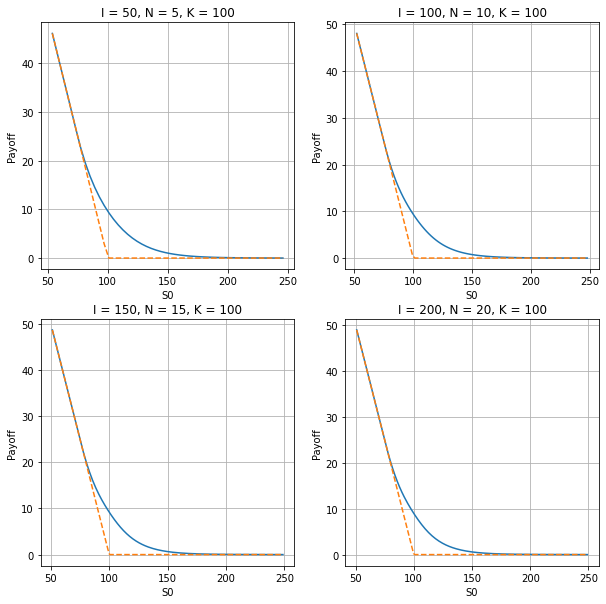

In [163]:
hs = []

dictionary = dic()
dictionary['e_k'].append(None)
dictionary['order_alpha_k'].extend([None, None])
  
Is = [50, 100, 150, 200]
plt.figure(figsize=(10, 10))
for i in range(len(Is)):
    plt.subplot(2,2,i+1)
    I = Is[i]
    N = I//10
    plot('BDF', I, N)
    
    bs = BS(N=N, I=I)
    s_ = bs.Sval
    U_s = P1(s_, bs, 'BDF')
    hs.append(bs.h)
    dictionary['I'].append(I)
    dictionary['N'].append(N)
    dictionary['U(s_)'].append(U_s)
    if i > 0:
        dictionary['e_k'].append(dictionary['U(s_)'][i] -
                                 dictionary['U(s_)'][i - 1])
    if i > 1:
        e_k_1, e_k = dictionary['e_k'][i - 1:i + 1]
        h_k_1, h_k = hs[i - 1:i + 1]
        dictionary['order_alpha_k'].append(
            get_order_alpha(e_k_1, e_k, h_k_1, h_k))

df = pd.DataFrame.from_dict(dictionary)
df.round(5)